In [1]:
import scan_csv
from FastSlidingWindow import *
from Util import *
from bbd100k_loader import *
from scan_csv import progress

loader = BBD100K_Loader(True)
color_map = generate_color_from_categories(loader.category_dict)

In [2]:
import tensorflow as tf
import numpy as np
tf.enable_eager_execution()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
tf.Session(config=config).close()

In [3]:
def calc_iou(Y_pred, Y):
    #print(Y_pred.shape)
    zeros = np.zeros([Y_pred.shape[0], Y_pred.shape[1], Y_pred.shape[2], 1], dtype=np.float32)
    y2 = tf.reshape(Y_pred[:, :, :, 2], [Y_pred.shape[0], Y_pred.shape[1], Y_pred.shape[2], 1])
    y4 = tf.reshape(Y_pred[:, :, :, 4], [Y_pred.shape[0], Y_pred.shape[1], Y_pred.shape[2], 1])
    pred_x_w = tf.where(y2 > 0.0, y2, zeros) 
    pred_x_h = tf.where(y4 > 0.0, y4, zeros) 
    
    x1_t = Y_pred[:, :, :, 1:2] - Y[:, :, :, 2:3] / 2.0
    x2_t = Y_pred[:, :, :, 1:2] + Y[:, :, :, 2:3] / 2.0
    
    y1_t = Y_pred[:, :, :, 3:4] - Y[:, :, :, 4:5] / 2.0
    y2_t = Y_pred[:, :, :, 3:4] + Y[:, :, :, 4:5] / 2.0
    
    x1_p = Y_pred[:, :, :, 1:2] - pred_x_w / 2.0
    x2_p = Y_pred[:, :, :, 1:2] + pred_x_w / 2.0
    
    y1_p = Y_pred[:, :, :, 3:4] - pred_x_h / 2.0
    y2_p = Y_pred[:, :, :, 3:4] + pred_x_h / 2.0
    
    cond1 = x2_t < x1_p
    cond2 = x2_p < x1_t
    cond3 = y2_t < y1_p
    cond4 = y2_p < y1_t
    cond_all = tf.logical_or(tf.logical_or(tf.logical_or(cond1, cond2), cond3), cond4)
    
    ious_np = np.zeros([Y_pred.shape[0], Y_pred.shape[1], Y_pred.shape[2], 1], dtype=np.float32)
    
    far_x = tf.where(x2_t < x2_p, x2_t, x2_p)
    near_x = tf.where(x1_t > x1_p, x1_t, x1_p)
    far_y = tf.where(y2_t < y2_p, y2_t, y2_p)
    near_y = tf.where(y1_t > y1_p, y1_t, y1_p)
    
    inter_area = (far_x - near_x + 1.0) * (far_y - near_y + 1.0)
    true_box_area = (x2_t - x1_t + 1.0) * (y2_t - y1_t + 1.0)
    pred_box_area = (x2_p - x1_p + 1.0) * (y2_p - y1_p + 1.0)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    iou = tf.where(cond_all, ious_np, iou)
    return iou
    
#iou_1 = calc_iou(Y_pred, Y)
#iou = 1.0 - tf.reduce_mean(iou_1)

In [4]:
w_val = 0.1
W_M_1 = tf.Variable(np.random.uniform(-w_val, w_val, [3, 3, 3, 32]), dtype=tf.float32, name='WM1')
W_M_1_1 = tf.Variable(np.random.uniform(-w_val, w_val, [3, 3, 32, 64]), dtype=tf.float32, name='WM11')
W_M_2 = tf.Variable(np.random.uniform(-w_val, w_val, [3, 3, 64, 128]), dtype=tf.float32, name='WM2')
W_M_2_1 = tf.Variable(np.random.uniform(-w_val, w_val, [3, 3, 128, 256]), dtype=tf.float32, name='WM21')
W_M_2_2 = tf.Variable(np.random.uniform(-w_val, w_val, [3, 3, 256, 256]), dtype=tf.float32, name='WM22')
W_M_2_3 = tf.Variable(np.random.uniform(-w_val, w_val, [3, 3, 256, 512]), dtype=tf.float32, name='WM23')
W_M_2_4 = tf.Variable(np.random.uniform(-w_val, w_val, [2, 2, 512, 256]), dtype=tf.float32, name='WM24')
W_M_3 = tf.Variable(np.random.uniform(-w_val, w_val, [2*2*256, 256]), dtype=tf.float32, name='WM3')
W_M_3_1 = tf.Variable(np.random.uniform(-w_val, w_val, [256, 128]), dtype=tf.float32, name='WM31')

W_M_C = tf.Variable(np.random.uniform(-w_val, w_val, [128*5, 128]), dtype=tf.float32, name='WMC')

W_M_4_F = tf.Variable(np.random.uniform(-w_val, w_val, [128, len(loader.category_dict)*5]), 
                      dtype=tf.float32, name='WM4F')

params = [W_M_1, W_M_1_1, W_M_2, W_M_2_1, W_M_2_2, W_M_2_3, 
          W_M_2_4, W_M_3, W_M_3_1, W_M_4_F, W_M_C]

In [5]:
# 1 must be added for shifted
def index_lookup_generator(w, h):
    indices = np.zeros([w, h, 5, 2], dtype=np.int32)
    for i in range(w):
        for j in range(h):
            l = [[i, j-1], [i, j+1], [i, j], [i-1, j], [i+1, j]]
            indices[i, j] = l
    return indices

In [6]:
def save_weights(params, extention=''):
    for p in params:
        np.save("weights/"+p.name.replace(':', '_')+'_'+extention, p.numpy())
        
def load_weights(params, extention=''):
    for p in params:
        p.assign(np.load("weights/"+p.name.replace(':', '_')+'_'+extention+'.npy'))

In [18]:
def feed_forward(X):
    X_flat = tf.reshape(X, [X.shape[0]*X.shape[1], X.shape[2], X.shape[3], X.shape[4]])
    encode_conv = tf.nn.leaky_relu(tf.nn.conv2d(X_flat, W_M_1, [1, 2, 2, 1], 'SAME'), alpha=0.1)
    encode_conv = tf.nn.leaky_relu(tf.nn.conv2d(encode_conv, W_M_1_1, [1, 2, 2, 1], 'SAME'), alpha=0.1)
    share_conv = encode_conv

    share_conv = tf.nn.leaky_relu(tf.nn.conv2d(share_conv, W_M_2, [1, 2, 2, 1], 'SAME'), alpha=0.1)
    share_conv = tf.nn.leaky_relu(tf.nn.conv2d(share_conv, W_M_2_1, [1, 2, 2, 1], 'SAME'), alpha=0.1)
    share_conv = tf.nn.leaky_relu(tf.nn.conv2d(share_conv, W_M_2_2, [1, 2, 2, 1], 'SAME'), alpha=0.1)
    share_conv = tf.nn.leaky_relu(tf.nn.conv2d(share_conv, W_M_2_3, [1, 1, 1, 1], 'VALID'), alpha=0.1)
    share_conv = tf.nn.leaky_relu(tf.nn.conv2d(share_conv, W_M_2_4, [1, 1, 1, 1], 'VALID'), alpha=0.1)
    #print(share_conv.shape)
    
    share_flat = tf.reshape(share_conv, [share_conv.shape[0], W_M_3.shape[0]])
    flat_1 = tf.nn.leaky_relu(tf.matmul(share_flat, W_M_3), alpha=0.1)
    flat_2 = tf.nn.leaky_relu(tf.matmul(flat_1, W_M_3_1), alpha=0.1)
        
    flat_2 = tf.reshape(flat_2, [X.shape[0], X.shape[1], flat_2.shape[1]])
    padded = tf.pad(flat_2, [[1, 1], [1, 1], [0, 0]])
    indices = index_lookup_generator(X.shape[0], X.shape[1]) + 1
    collaborations = tf.gather_nd(padded, indices)
    collaborations = tf.reshape(collaborations, [X.shape[0], X.shape[1], collaborations.shape[-1]*5])
    collaborations = tf.reshape(collaborations, [X.shape[0] * X.shape[1], collaborations.shape[-1]])
    final =  tf.nn.leaky_relu(tf.matmul(collaborations, W_M_C), alpha=0.1)
    
    for i in range(2):
        final = tf.reshape(final, [X.shape[0], X.shape[1], final.shape[1]])
        padded = tf.pad(final, [[1, 1], [1, 1], [0, 0]])
        collaborations = tf.gather_nd(padded, indices)
        collaborations = tf.reshape(collaborations, [X.shape[0], X.shape[1], collaborations.shape[-1]*5])
        collaborations = tf.reshape(collaborations, [X.shape[0] * X.shape[1], collaborations.shape[-1]])
        final =  tf.nn.leaky_relu(tf.matmul(collaborations, W_M_C), alpha=0.1)
    
    Y_pred = tf.matmul(final, W_M_4_F)
    Y_pred = tf.reshape(Y_pred, [Y_pred.shape[0], len(loader.category_dict), 5])
    Y_pred = tf.reshape(Y_pred, [X.shape[0], X.shape[1], len(loader.category_dict), 5])
    
    class_pred = tf.nn.sigmoid(Y_pred[:, :, :, 0])
    xc_pred = Y_pred[:, :, :, 1]
    yc_pred = Y_pred[:, :, :, 3]
    xw_pred = tf.square(Y_pred[:, :, :, 2])
    yw_pred = tf.square(Y_pred[:, :, :, 4])
    
    #Y_pred = tf.nn.leaky_relu(Y_pred, alpha=0.5)
    Y_pred = tf.stack([class_pred, 
                       xc_pred, 
                       xw_pred, 
                       yc_pred, 
                       yw_pred], axis=3)

    return Y_pred

In [8]:
def mean_squared(inputs, targets):
    error = tf.to_double(inputs) - tf.to_double(targets)
    return tf.reduce_mean(tf.square(error))

def bbox_loss(Y_pred, Y):
    ms = tf.square(1.0 + mean_squared(Y_pred[:, :, 0], Y[:, :, 0]))
    xm = tf.square(1.0 + mean_squared(Y_pred[:, :, 1], Y[:, :, 1]))
    ym = tf.square(1.0 + mean_squared(Y_pred[:, :, 3], Y[:, :, 3]))
    xwm = mean_squared(Y_pred[:, :, 2], Y[:, :, 2])
    ywm = mean_squared(Y_pred[:, :, 4], Y[:, :, 4])
    return ms+xm+ym+xwm+ywm

def back_prop(X, Y):
    #y_m = np.mean(Y[:, :, :, 0], axis=2) >= 0.0
    #Y_true = Y[y_m]
    #X_flat = X[y_m]
    Y_true = tf.reshape(Y, [Y.shape[0]*Y.shape[1], Y.shape[2], Y.shape[3]])
    X_flat = tf.reshape(X, [X.shape[0]*X.shape[1], X.shape[2], X.shape[3], X.shape[4]])
    
    encode_conv = tf.nn.leaky_relu(tf.nn.conv2d(X_flat, W_M_1, [1, 2, 2, 1], 'SAME'), alpha=0.1)
    encode_conv = tf.nn.leaky_relu(tf.nn.conv2d(encode_conv, W_M_1_1, [1, 2, 2, 1], 'SAME'), alpha=0.1)
    share_conv = encode_conv

    share_conv = tf.nn.leaky_relu(tf.nn.conv2d(share_conv, W_M_2, [1, 2, 2, 1], 'SAME'), alpha=0.1)
    share_conv = tf.nn.leaky_relu(tf.nn.conv2d(share_conv, W_M_2_1, [1, 2, 2, 1], 'SAME'), alpha=0.1)
    share_conv = tf.nn.leaky_relu(tf.nn.conv2d(share_conv, W_M_2_2, [1, 2, 2, 1], 'SAME'), alpha=0.1)
    share_conv = tf.nn.leaky_relu(tf.nn.conv2d(share_conv, W_M_2_3, [1, 1, 1, 1], 'VALID'), alpha=0.1)
    share_conv = tf.nn.leaky_relu(tf.nn.conv2d(share_conv, W_M_2_4, [1, 1, 1, 1], 'VALID'), alpha=0.1)
    #print(share_conv.shape)
    
    share_flat = tf.reshape(share_conv, [share_conv.shape[0], W_M_3.shape[0]])
    flat_1 = tf.nn.leaky_relu(tf.matmul(share_flat, W_M_3), alpha=0.1)
    flat_2 = tf.nn.leaky_relu(tf.matmul(flat_1, W_M_3_1), alpha=0.1)
        
    flat_2 = tf.reshape(flat_2, [X.shape[0], X.shape[1], flat_2.shape[1]])
    padded = tf.pad(flat_2, [[1, 1], [1, 1], [0, 0]])
    indices = index_lookup_generator(X.shape[0], X.shape[1]) + 1
    collaborations = tf.gather_nd(padded, indices)
    collaborations = tf.reshape(collaborations, [X.shape[0], X.shape[1], collaborations.shape[-1]*5])
    collaborations = tf.reshape(collaborations, [X.shape[0] * X.shape[1], collaborations.shape[-1]])
    final =  tf.nn.leaky_relu(tf.matmul(collaborations, W_M_C), alpha=0.1)
    
    for i in range(2):
        final = tf.reshape(final, [X.shape[0], X.shape[1], final.shape[1]])
        padded = tf.pad(final, [[1, 1], [1, 1], [0, 0]])
        collaborations = tf.gather_nd(padded, indices)
        collaborations = tf.reshape(collaborations, [X.shape[0], X.shape[1], collaborations.shape[-1]*5])
        collaborations = tf.reshape(collaborations, [X.shape[0] * X.shape[1], collaborations.shape[-1]])
        final =  tf.nn.leaky_relu(tf.matmul(collaborations, W_M_C), alpha=0.1)
    
    Y_pred = tf.matmul(final, W_M_4_F)
    Y_pred = tf.reshape(Y_pred, [Y_pred.shape[0], len(loader.category_dict), 5])
    
    class_pred = tf.nn.sigmoid(Y_pred[:, :, 0])
    xc_pred = Y_pred[:, :, 1]
    yc_pred = Y_pred[:, :, 3]
    xw_pred = tf.square(Y_pred[:, :, 2])
    yw_pred = tf.square(Y_pred[:, :, 4])
    
    #Y_pred = tf.nn.leaky_relu(Y_pred, alpha=0.5)
    Y_pred = tf.stack([class_pred, 
                       xc_pred, 
                       xw_pred, 
                       yc_pred, 
                       yw_pred], axis=2)
    
    loss_value = bbox_loss(Y_pred, Y_true)
    return loss_value

In [9]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
loss_values = []
index = 0
loss = 0.0

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

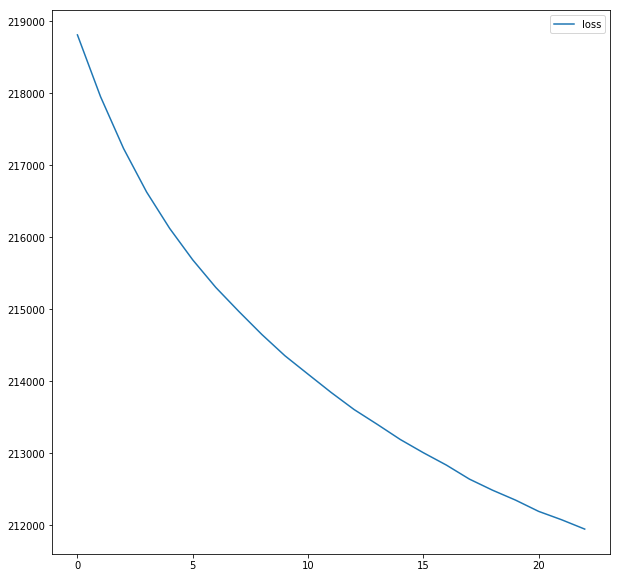

 211946.82494168554


In [ ]:
%matplotlib inline
import sys
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

def plot_loss(losses):
    losses_np = np.array(losses)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(figsize=(10, 10))
    plt.plot(losses_np, label='loss')
    plt.legend()
    plt.show()
    
patch_size = 150
stride = 50

while True:
    X, Y, image, cmap = loader.gather(index, stride, patch_size, 0.1)
    
    if image is not None:
        if np.max([image.shape[0], image.shape[1]]) >= 2000:
            image = None

    if image is not None:
        with tf.GradientTape() as tape:
            loss_value = back_prop(X, Y)

        loss += loss_value.numpy()
        if loss_value.numpy() < 0.0:
            print('dun goofd')
            break
            
        grads_and_vars = tape.gradient(loss_value, params)
        capped_grads_and_vars = [tf.clip_by_value(gv, -5., 5.) for gv in grads_and_vars]
        optimizer.apply_gradients(zip(capped_grads_and_vars, params), 
                                              global_step=tf.train.get_or_create_global_step()) 
        
        Y_pred = feed_forward(X)
        img_orig = draw_from_label(image, Y, cmap, patch_size, color_map, 0.1, draw_patches=False, 
                                   max_count=1000)
        img_pred = draw_from_label(image, Y_pred.numpy(), cmap, patch_size, color_map, 0.9, 
                                   max_count=100, draw_patches=False)

        cv2.imshow('orig', img_orig)
        cv2.imshow('pred', img_pred)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
    progress(index, loader.image_count, index)
    index += 1
    if index % 100 == 0:
        save_weights(params, extention='bckp')
    if index >= loader.image_count:
        index = 0
        loss_values.append(loss)
        plot_loss(loss_values)
        print(' ' + str(loss))
        loss = 0.0

In [10]:
load_weights(params, 'bckp')

In [35]:
X, Y, image, cmap = loader.gather(333, stride, patch_size, 0.1)
Y_pred = feed_forward(X)
while(True):
    img_orig = draw_from_label(image, Y, cmap, patch_size, color_map, 0.1, draw_patches=False, max_count=1000)
    img_pred = draw_from_label(image, Y_pred.numpy(), cmap, patch_size, color_map, 0.9, draw_patches=True)
    cv2.imshow('orig', img_orig)
    cv2.imshow('pred', img_pred)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

In [44]:
# test
cap = cv2.VideoCapture('drive_footage.mp4')
indices = None
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret is False:
        break
    X, cmap, indices = eager_sliding_window(frame, stride, patch_size, indices)
    if isinstance(indices, np.ndarray):
        indices = tf.Variable(indices)
        print('swapped')
    Y_pred = feed_forward(X)
    drawn = draw_from_label(frame, Y_pred.numpy(), cmap, 
                                   patch_size, color_map, 0.99, draw_patches=False, max_count=10000)
    cv2.imshow('frame', drawn)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break
cv2.destroyAllWindows()

swapped


In [ ]:
W_M_1.numpy()